# Etiquetado de Conformaciones

In [3]:
import pandas as pd
import numpy as np
import pytraj as pyt
import csv
import ast
import datetime
import matplotlib.pyplot as plt
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
import glob, sys, os
sys.path.append(r'..')

In [4]:
from modules.MDS import cMDS
from modules.plotting_functions import plot_points, plot_anotation_labels

### Tabla de datos con las 402 estructuras

In [5]:
prot_name = 'cdk2'

In [7]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO.json')))[0]
                      
df_prot = pd.read_json(path_to_json_file)
df_prot.head()

Title       Date  Entities  \
1aq1  human cyclin dependent kinase 2 complexed with... 1997-11-12         1   
1b38                    human cyclin-dependent kinase 2 1998-12-23         1   
1b39  human cyclin-dependent kinase 2 phosphorylated... 1998-12-23         1   
1buh  crystal structure of the human cdk2 kinase com... 1998-09-09         2   
1ckp  human cyclin dependent kinase 2 complexed with... 1999-01-13         1   

     ChainID  Resolution  Identity   Coverage  NumGaps   GapLen  \
1aq1       A        2.00       298  92.953020        2  [9, 14]   
1b38       A        2.00       298  97.315436        1      [9]   
1b39       A        2.10       298  97.315436        1      [9]   
1buh       A        2.60       298  96.308725        2   [8, 5]   
1ckp       A        2.05       298  93.624161        2  [9, 12]   

                      GapPos  NumLigs        NameLigs Inhib  Inhib_mass  
1aq1  [[36, 44], [149, 162]]        1           [STU]   STU       440.0  
1b38              [[36, 44]]        3  [ACE, ATP, MG]   ATP       398.0  
1b39              [[36, 44]]        3  [ACE, ATP, MG]   ATP       398.0  
1buh  [[40, 47], [295, 299]]        0              []  None         NaN  
1ckp  [[36, 44], [153, 164]]        2      [EDO, PVB]   PVB       214.0

### Carga de las 402 estructuras

In [24]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = (os.path.join('..', '..', 'ARCHIVOS', 'CRISTALES', 'TRAJ_CRISTALS_PDB',
                        F'PDB_402_cdk2_PISANI_ALL.pdb'))
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


### Etiquetado de las estructuras según su conformación

In [19]:
# Esta función permite etiquetar las estructuras de la proteína CDK2
from modules.label_cdk2_confs import label_cdk2_conformations

In [20]:
# Función para etiquetar cada estructura
labels_cdk2 = label_cdk2_conformations(traj_crystals)
df_prot["Labels_conf"] = labels_cdk2
df_prot.iloc[:, -10:].head(5)

Identity   Coverage  NumGaps   GapLen                  GapPos  NumLigs  \
1aq1       298  92.953020        2  [9, 14]  [[36, 44], [149, 162]]        1   
1b38       298  97.315436        1      [9]              [[36, 44]]        3   
1b39       298  97.315436        1      [9]              [[36, 44]]        3   
1buh       298  96.308725        2   [8, 5]  [[40, 47], [295, 299]]        0   
1ckp       298  93.624161        2  [9, 12]  [[36, 44], [153, 164]]        2   

            NameLigs Inhib  Inhib_mass Labels_conf  
1aq1           [STU]   STU       440.0     inact_b  
1b38  [ACE, ATP, MG]   ATP       398.0     inact_a  
1b39  [ACE, ATP, MG]   ATP       398.0     inact_a  
1buh              []  None         NaN     inact_a  
1ckp      [EDO, PVB]   PVB       214.0     inact_a

### Guardamos una nueva tabla con las etiquetas
**Guardamos un archivo _json_ para su posterior uso**

In [21]:
file_df_prot_confLabels = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json')))[0]
if False: # Activar para guardar
    df_cdk2.to_json(file_df_prot_confLabels)

### Subsecuencias de la proteína

In [22]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")

&nbsp; 
## Filtrado de las estructuras usadas por Pisani (2016)
Existen **tres filtros** que debemos aplicar para tratar de seleccionar las mismas 255 estructuras de Pisiani. Dos de estos filtros los dan los autores:
- Todas las estructuras cuyo valor de **resolución sea menor o igual a 2.5 A**
- Todas las estructuras que **NO** carezcan de *ninguno* de los residuos que mencionan en su lista (residuos de Pisani).

Para aplicar el segundo filtro es necesaria la siguiente función:

In [23]:
# Filtrado de las estructuras
# Primera condición
res_25_A_o_menos = df_prot.Resolution <= 2.5

# Segunda condición
from modules.find_gaps import is_a_gap
no_gaps_en_seq = df_prot.GapPos.apply( lambda x: is_a_gap(x, get_pisani_residues(x="list")) )

# Tercera condición: ¿Cuántas y cuáles de las estructuras se publicaron como máximo hasta 2015?
fecha_2015_o_menos = df_prot.Date.apply(lambda x:  x.year  <= 2015)

# Obtenemos los índices resultantes
frames_pisani = np.array((res_25_A_o_menos) & (no_gaps_en_seq) & (fecha_2015_o_menos))

#### Guardamos los indices de los frames que pertenecen a las estructuras usadas por Pisani

In [24]:
# guardamos los indices correspondientes a los frames de pisani
file_pisani_frames = (os.path.join('..', 'data', 
                        '255_frames_pisani_2016'))
np.save(file_pisani_frames, frames_pisani)

&nbsp;
## Classical Multidimentional Scaling
### Matriz de disimilitud
#### RMSD alineando por residuos usados por Pisani
Utilizamos *pytraj* para generar la matrix de disimilitud con la métrica *RMSD* en las **255** estructuras usadas por Pisani.

In [25]:
# Máscara indicando los CA de los residuos de Pisani
pisani_mask = F"(:{pisiani_residues})&(@CA)"

# RMSD por pares de las 402 estructuras
pair_rmsd_402_struc = pyt.pairwise_rmsd( traj = traj_crystals, mask= pisani_mask, metric="rms")

# Subset de RMSD por pares usando sólo sus 255 estructuras
pair_rmsd_pisani = pair_rmsd_402_struc[:, frames_pisani][frames_pisani, :]

**Matrices dedidimilitud**

In [30]:
import seaborn as sns
sns.set(context = 'talk', style = 'white')

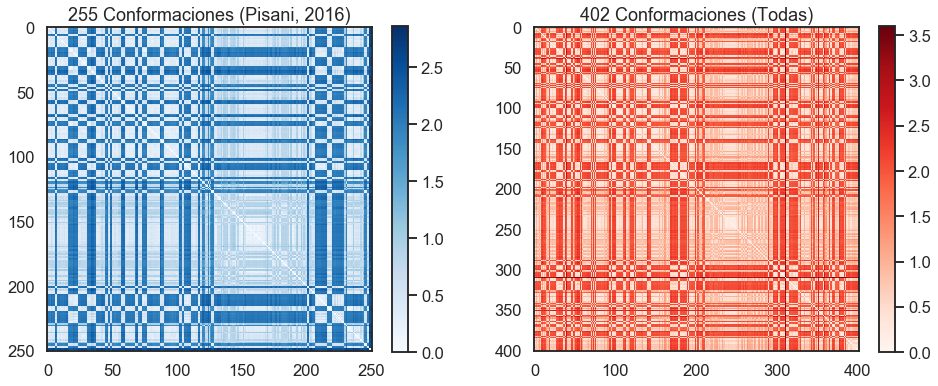

In [31]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 20})
plt.subplot(1, 2, 1)
plt.title("255 Conformaciones (Pisani, 2016)")
plt.imshow(pair_rmsd_pisani, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

plt.subplot(1, 2, 2)
plt.title("402 Conformaciones (Todas)")
plt.imshow(pair_rmsd_402_struc, zorder=2, cmap='Reds', interpolation='nearest')
plt.colorbar();

### Generación del cMDS
#### Ensamble de 255 estructuras cristalográficas de CDK2
Vamos a crear un ensamble con las 255 estructuras, a partir de los CA de las cadenas A de cada proteína. Al leer cada estructura sólo se tomarán en cuenta los CA, y para el análisis de RMSD y MSD sólo los residuos definidos por Pisani.

In [27]:
# MDS, usamos la función que previamente habíamos definido en moduloes.cMDS
# MDS con los 255 Frames de Pisani
mds_pisani = cMDS(pair_rmsd_pisani)

# MDS con las 402 conformaciones
mds_total = cMDS(pair_rmsd_402_struc)

#### Estructuras de referencia

In [28]:
# Estructuras de  referencia que queremos mostrar en la gráfica
# Éstas son las estructuras que Pisani usa como referencia
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}

#### Gráfica de MDS de Pisani (2016)

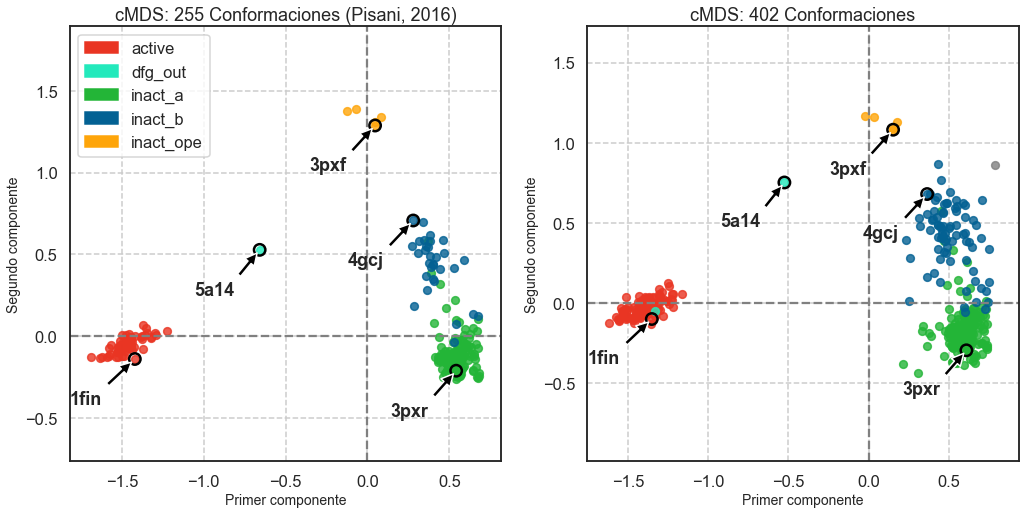

In [106]:
# Etiquetas según el PDB ID de cada estructura
traj_labels_pisani = df_prot.index[frames_pisani]
# Se genera la gráfica
fig = plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plot_points(mds = mds_pisani[0], labels = df_prot.Labels_conf[frames_pisani], alpha=0.8, legend = True, 
                             title = "cMDS: 255 Conformaciones (Pisani, 2016)")
plot_anotation_labels(df_prot.index[frames_pisani],  ref_structs_dict.keys(), 
                      mds_pisani[0][0], mds_pisani[0][1], xytext_delta=[0.4, 0.3], s=130)
 
plt.subplot(1, 2, 2)
plot_points(mds = mds_total[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), mds_total[0][0], mds_total[0][1], xytext_delta=[0.4, 0.3], s=130)

In [120]:
# Señalar las conformaciones que están en CSAR
df_csar_2012 = pd.read_json('../data/csar_Binding_Data_Corrected_2016.json')
csar_pdb_ids = np.array(df_csar_2012['PDB ID'][df_csar_2012['PDB ID'].notnull()])
csar_pdb_ids = [i.lower() for i in csar_pdb_ids]

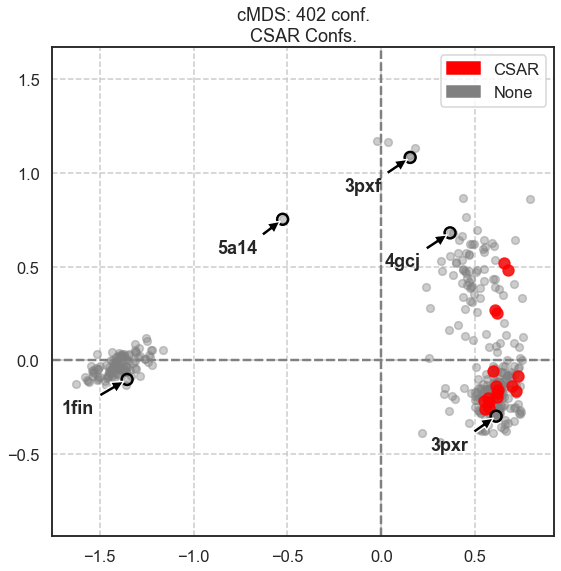

In [122]:
# Ahora procedemos a graficar
ligand_colors = ['red', 'gray']
csar_labels = np.array(['CSAR' if i in csar_pdb_ids else 'None' for i in df_prot.index])
label_mask = csar_labels != 'CSAR'

fig = plt.figure(figsize=(9, 9))
plot_points(mds = mds_total[0], alpha = 0.4, colors_list=['gray'])
plot_points(mds = mds_total[0], labels = csar_labels, 
             alpha = 0.8, colors_list=ligand_colors,
            legend=True, general_font_size= 20, xlabel="", ylabel="", point_size=120, 
            title = "cMDS: 402 conf.\nCSAR Confs.")
plot_anotation_labels(df_prot.index,ref_structs_dict.keys(), 
                      mds_total[0][0], mds_total[0][1], xytext_delta=[0.35, 0.2], s=120)

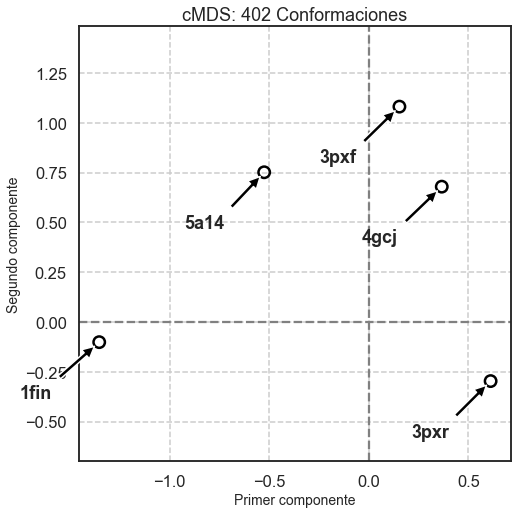

In [98]:
csar_labels = ['casar' if i in csar_pdb_ids else 'None' for i in df_prot.index]
ligand_colors = ['#E93523', '#FEA50A', 'gray']
# Etiquetas según el PDB ID de cada estructura
traj_labels_pisani = df_prot.index[frames_pisani]
# Se genera la gráfica
fig = plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plot_points(mds = mds_total[0], labels = csar_labels, alpha=0.8, 
            title = "cMDS: 402 Conformaciones", colors_list=ligand_colors)
plot_anotation_labels(df_prot.index, ref_structs_dict.keys(), 
                      mds_total[0][0], mds_total[0][1], xytext_delta=[0.4, 0.3], s=130)

## Etiquetas por frecuencia de ligando acoplado

In [52]:
# Comenzamos preguntando qué ligandos se repiten en las diferentes estructuras
df_prot.Inhib.value_counts()

ATP    15
4SP     6
1RO     5
2AN     4
ADP     4
       ..
FCQ     1
X75     1
Z02     1
292     1
LS4     1
Name: Inhib, Length: 315, dtype: int64

In [124]:
# Ahora procedemos a crear una lista de etiquetas para identificar conformaciones que tengan ligandos repetidos
prot_ligands = df_prot.Inhib.fillna('No_lig')

# Preguntamos qué  ligandos aprecen más de cierto número de veces entre las confromaciones
lig_freq_cutoff = 8
ligs_freq_n_times = prot_ligands.value_counts()[prot_ligands.value_counts() > lig_freq_cutoff].index

# Ahora creamos una lista en donde sólo se resalten las conformaciones con éstos ligandos
ligand_labels = np.array([i if i in ligs_freq_n_times else 'Other' for i in prot_ligands])

In [83]:
# Ahora procedemos a graficar
ligand_colors = ['#E93523', '#FEA50A', 'gray']
label_mask = ligand_labels != 'Other'

fig = plt.figure(figsize=(9, 9))
plot_points(mds = mds_total[0], labels = ligand_labels, colors_list = ligand_colors, alpha = 0.4)
plot_points(mds = mds_total[0][: , label_mask], labels = ligand_labels[label_mask], 
            colors_list = ligand_colors, alpha = 0.6,
            legend=True, general_font_size= 20, xlabel="", ylabel="", point_size=120, 
            title = "cMDS: 402 conf.\nColor por ligando (Más frecuentes -incluyendo No_lig)")
plot_anotation_labels(df_prot.index,ref_structs_dict.keys(), 
                      mds_total[0][0], mds_total[0][1], xytext_delta=[0.35, 0.2], s=120)

NameError: name 'ligand_labels' is not defined

## Etiquetas por algún criterio que defina a los ligandos
### En este ejemplo es por el Grupo al que pertenece cada ligando tras un clustering por similitud de tanimoto
**Cargamos de un archivo de _json_ , generado en la libreta "Análisis de ligandos cristales"**

In [17]:
import json

In [18]:
# Cargamos los datos del archivo json
with open("./B_DATOS/dict_ligs_cristales_etiquetados_por_grupo_tanimoto.json", "r") as f:
    dic_to_save_ligs = json.load(f)

Incluimos cada etiqueta en el dataframe general.

In [19]:
# Inicializamos la columna con el valor 5
df_cdk2["Label_lig_g_tan"] = 5
# Ahora incluimos la etiqueta, que va del 0 al 4, para el caso de las moléculas que tienen ligandos:
for pdb_id in dic_to_save_ligs["ColorLabel"].keys():
    df_cdk2.at[pdb_id, "Label_lig_g_tan"] = dic_to_save_ligs["ColorLabel"][pdb_id]
df_cdk2.head(5)

Title       Date  \
PDB_ID                                                                 
1aq1    human cyclin dependent kinase 2 complexed with... 1997-11-12   
1b38                      human cyclin-dependent kinase 2 1998-12-23   
1b39    human cyclin-dependent kinase 2 phosphorylated... 1998-12-23   
1buh    crystal structure of the human cdk2 kinase com... 1998-09-09   
1ckp    human cyclin dependent kinase 2 complexed with... 1999-01-13   

        Entities ChainID  Resolution  Identity   Coverage  NumGaps   GapLen  \
PDB_ID                                                                        
1aq1           1       A        2.00     298.0  92.953020      2.0  [8, 13]   
1b38           1       A        2.00     298.0  97.315436      1.0      [8]   
1b39           1       A        2.10     298.0  97.315436      1.0      [8]   
1buh           2       A        2.60     298.0  96.308725      2.0   [7, 4]   
1ckp           1       A        2.05     298.0  93.624161      2.0  [8, 11]   

                        GapPos  NumLigs              NameLigs Inhib  \
PDB_ID                                                                
1aq1    [[36, 43], [149, 161]]      1.0               ['STU']   STU   
1b38                [[36, 43]]      3.0  ['ACE', 'ATP', 'MG']   ATP   
1b39                [[36, 43]]      3.0  ['ACE', 'ATP', 'MG']   ATP   
1buh    [[40, 46], [295, 298]]      0.0                    []         
1ckp    [[36, 43], [153, 163]]      2.0        ['EDO', 'PVB']   PVB   

       Inhib_mass Labels_conf  Label_lig_g_tan  
PDB_ID                                          
1aq1        440.0     inact_b                1  
1b38        398.0     inact_a                4  
1b39        398.0     inact_a                4  
1buh                  inact_a                5  
1ckp        214.0     inact_a                2

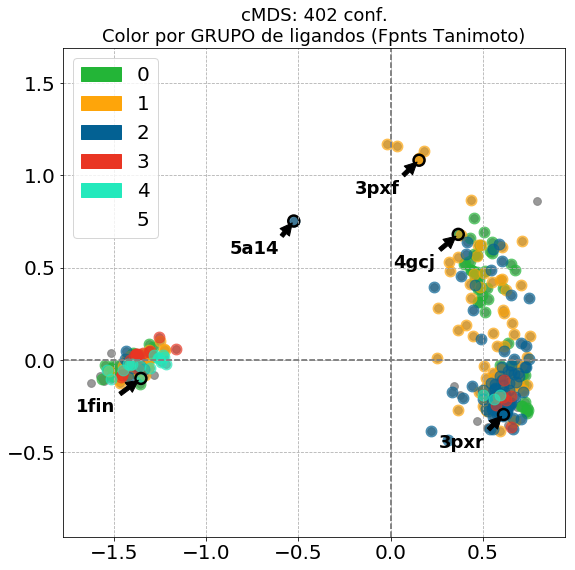

In [20]:
colores_grupo_lig = [ '#23B537', '#FEA50A', '#036193', '#E93523', '#23E9BC', 'none']

fig = plt.figure(figsize=(9, 9))
plot_mds_or_pca(mds = mds_total[0], alpha = 0.8, colors_list=["gray"], general_font_size= 20)
plot_mds_or_pca(mds = mds_total[0], labels = df_cdk2["Label_lig_g_tan"], colors_list = colores_grupo_lig, 
                legend=True, general_font_size= 20, xlabel="", ylabel="", point_size=120, alpha = 0.6,
                title = "cMDS: 402 conf.\nColor por GRUPO de ligandos (Fpnts Tanimoto)"
               )
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), mds_total[0][0], mds_total[0][1], xytext_delta=[0.35, 0.2], s=120)

#### Etiquetando las top 20 conformaciones con mejor AUC de los ligs de CSAR

In [21]:
best_conf_vinardo = ['2vv9', '2r3p', '6guf', '2iw8', '4eor', '1urw', '1vyz', '4fkj', '1h07',
       '4cfn', '4bzd', '2btr', '3unk', '3lfn', '2r64', '2c4g', '5nev', '1oiq', '3sqq', '3ig7']
best_conf_vina = ['3unj', '2r3o', '1oiq', '3tiz', '3rpy', '3ddp', '3unk', '2xnb', '4bzd',
       '3s0o', '3sw4', '2r64', '2c6m', '2r3k', '1pf8', '2r3m', '5fp6', '3eid', '3qu0', '3r9h']

labels_vinardo = np.array(["Vinardo" if i in best_conf_vinardo else "" for i in df_cdk2.index ])
labels_vina = np.array(["Vina" if i in best_conf_vina else "" for i in df_cdk2.index ])

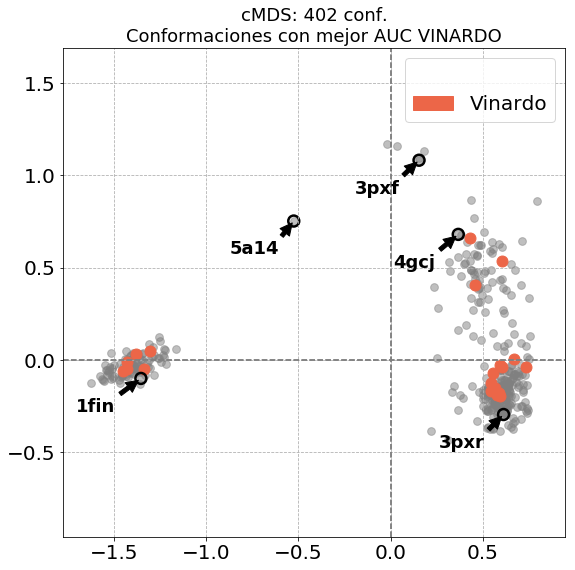

In [22]:
fig = plt.figure(figsize=(9, 9))
ligand_colors = ['none', "#EC6648"]
plot_mds_or_pca(mds = mds_total[0], alpha = 0.5, colors_list=["gray"], general_font_size= 20)
plot_mds_or_pca(mds = mds_total[0], labels = labels_vinardo, colors_list= ligand_colors, alpha = 1.0,
                legend=True, general_font_size= 20, xlabel="", ylabel="", point_size=120,
                title = "cMDS: 402 conf.\nConformaciones con mejor AUC VINARDO"
               )
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), mds_total[0][0], mds_total[0][1], xytext_delta=[0.35, 0.2], s=120)

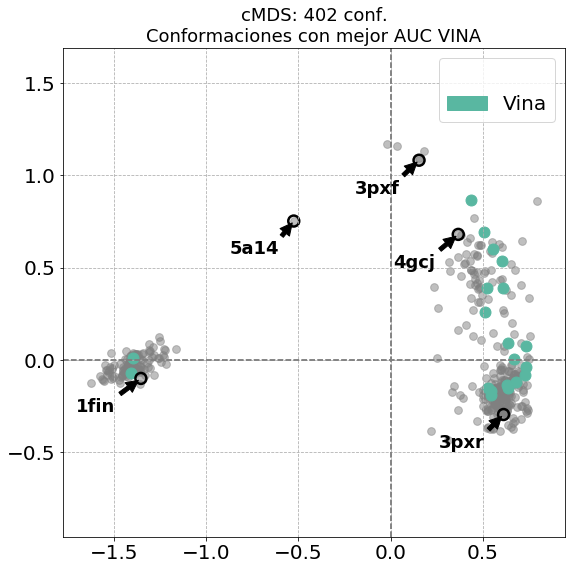

In [23]:
fig = plt.figure(figsize=(9, 9))
ligand_colors = ['none', "#59B7A1"]
plot_mds_or_pca(mds = mds_total[0], alpha = 0.5, colors_list=["gray"], general_font_size= 20)
plot_mds_or_pca(mds = mds_total[0], labels = labels_vina, colors_list= ligand_colors, alpha = 1.0,
                legend=True, general_font_size= 20, xlabel="", ylabel="", point_size=120,
                title = "cMDS: 402 conf.\nConformaciones con mejor AUC VINA"
               )
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), mds_total[0][0], mds_total[0][1], xytext_delta=[0.35, 0.2], s=120)

#### Plot RMSD vs primer frame

In [24]:
# Cálculo del RMSD contra el primer frame (estructura 1aq1)
rmsd_frame_1 = pyt.rmsd(traj_crystals, mask=F"@CA", ref=0, nofit = False, update_coordinate=False)

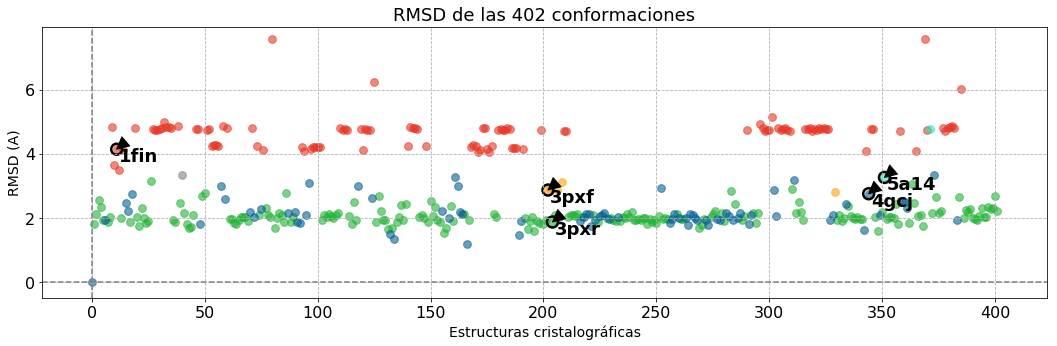

In [25]:
fig = plt.figure(figsize=(18, 5))
rmsd_plot = np.array([range(len(df_cdk2.Labels_conf)), rmsd_frame_1])
plot_mds_or_pca(rmsd_plot, labels = df_cdk2.Labels_conf, equal_axis=False,
                xlabel = "Estructuras cristalográficas", ylabel = "RMSD (A)", title = "RMSD de las 402 conformaciones")
plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), rmsd_plot[0], rmsd_plot[1], xytext_delta=[-1, 0.5], s=120)

&nbsp;
## Principal Component Analysis
#### Todos los $C\alpha$ de la secuencia vs $C\alpha$ de estructura secundaria (Pisani, 2016)
Para generar el PCA podemos usar *sklearn* o directamente el método *pca* de *pytraj*, los resultados son los mismos, y se pueden ver en la libreta de PCA. **Para cada subsecuencia evaluada la estructura es alineada previemente según dicha subsecuecia.**

In [26]:
# Todos los carbonos alfa
from sklearn.decomposition import PCA
pca_obj = PCA(copy=True, n_components= 2)

from sklearn.manifold import LocallyLinearEmbedding
lle_obj = LocallyLinearEmbedding(n_components= 2, n_neighbors=10)

def get_pca(pca_obj, traj, frames = None, atom_mask = "@CA"):
    ''' Retorna un objeto pca dada una trayectoria de pytraj y una mascara de selección'''
    if frames is None:
        frames = range(0, traj.n_frames)
    traj_subset = traj_crystals[frames, atom_mask]
    xyz_2d_array = traj_subset.xyz.reshape(traj_subset.n_frames, traj_subset.n_atoms * 3)
    pca = pca_obj.fit_transform( xyz_2d_array )
    return pca

- **PCA con todos los átomos:**

In [27]:
pyt.align(traj_crystals, "@CA")
pca_pyt_all = get_pca(pca_obj, traj_crystals, frames_pisani, "@CA")
# pca_pyt_all = pyt.pca( traj_crystals[frames_pisani], mask = "@CA", n_vecs=-1)

- **PCA con subsecuencia de Pisani:**

In [28]:
# Carbonos alfa de la subsecuencia de Pisani
pyt.align(traj_crystals, F"(:{pisiani_residues})&(@CA)")
pca_pyt_pisani  = get_pca(pca_obj, traj_crystals, frames_pisani, F"(:{pisiani_residues})&(@CA)")
# pca_pyt_pisani = pyt.pca( traj_crystals[frames_pisani], mask = F"(:{pisiani_residues})&(@CA)", n_vecs=-1)

- **PCA con la subsecuencia del _sitio activo_ (todos los $C\alpha$ del sitio activo)**

In [29]:
# Usando todos los carbonos alfa del pocket
pyt.align(traj_crystals, F"(:{pocket_residues})&(@CA)")
pca_pyt_pocket = get_pca(PCA(copy=True, n_components= 2), traj_crystals, frames_pisani, F"(:{pocket_residues})&(@CA)")
# pca_pyt_pocket = pyt.pca( traj_crystals[frames_pisani], mask = F"(:{pocket_residues})&(@CA)", n_vecs=-1)

- **PCA con la subsecuencia del _sitio activo_ (sólo $C\alpha$ de las estructuras secundarias)**  
Antes de hacer el análisis se determina que parte de la subsecuencia del sitio activo corresponde a regiones con estructura secundaria.

In [30]:
# Los índices indican [1] secuencia sec. en string, y [0] = frame 1
sec_secundaria_cdk2_f1 = pyt.dssp_analysis.dssp(traj_crystals, "@CA")[1][0]
# Obtenemos los residuos del pocket
struct_pocket = sec_secundaria_cdk2_f1[get_pocket_residues("list")]
# Cremos la lista de índices
secondary_pk_index = [ j for i, j in zip(struct_pocket, get_pocket_residues("list")) if i != '0' ]
secondary_pk_index_string = ",".join([str(i) for i in secondary_pk_index])

In [31]:
# Usando todos los carbonos alfa del pocket
pyt.align(traj_crystals, F"(:{secondary_pk_index_string})&(@CA)")
pca_pyt_pocket_sec = get_pca(PCA(copy=True, n_components= 2), traj_crystals, frames_pisani, F"(:{secondary_pk_index_string})&(@CA)")
# pca_pyt_pocket = pyt.pca( traj_crystals[frames_pisani], mask = F"(:{pocket_residues})&(@CA)", n_vecs=-1)

&nbsp;
### Gráficas del PCA con 255 estructuras de Pisani
Las siguientes graficas evaluan las 255 estructuras utilizadas por Pisani.

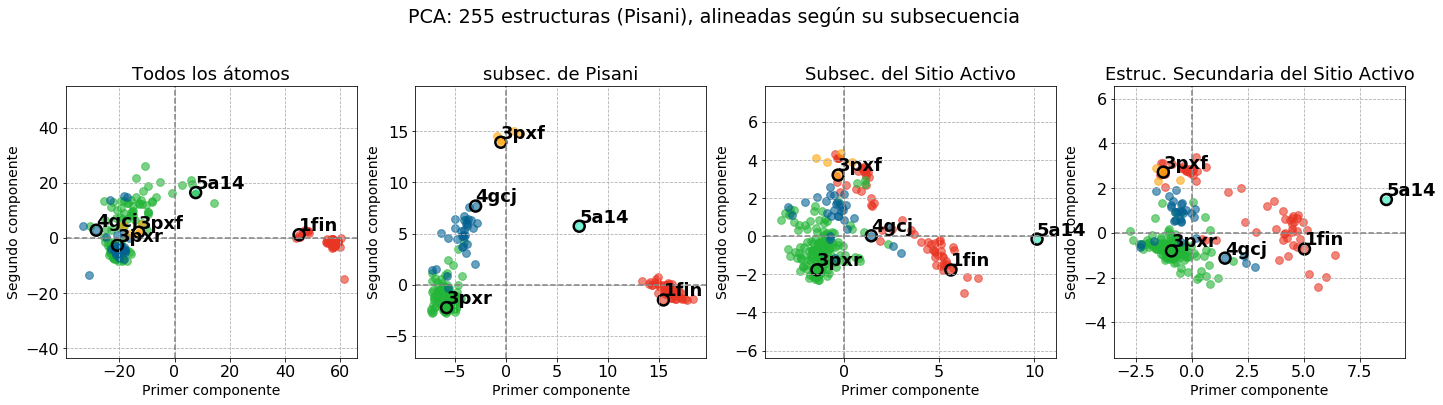

In [32]:
fig = plt.figure(figsize=(24, 5))
def plot_pca_pisani_structs(models, titles = ["Todos los átomos", "subsec. de Pisani", "Subsec. del Sitio Activo",
                                    "Estruc. Secundaria del Sitio Activo"]):
    for i, model in enumerate(models):
        plt.subplot(1, 4, i + 1)
        plot_mds_or_pca(mds = model.T, labels = df_cdk2[frames_pisani].Labels_conf,
                                     title = titles[i])
        plot_anotation_labels(df_cdk2[frames_pisani].index, ref_structs_dict.keys(), model[:,0], model[:,1], xytext_delta=[-0.0, 0.0], s=120)

plot_pca_pisani_structs([pca_pyt_all, pca_pyt_pisani, pca_pyt_pocket, pca_pyt_pocket_sec])
plt.suptitle("PCA: 255 estructuras (Pisani), alineadas según su subsecuencia", y = 1.1);

#### Diferentes subsets para el PCA a partir del mismo subset de alineamiento
Las gráficas de abajo evalúan  cómo cambian los resultados cuando **las estructuras son superpuestas utilizando un _subset_ de átomos** (por ejemplo las estructuras secundarias de Pisani) pero el **PCA es generado usando otro _subset_** de átomos.

In [33]:
def generate_new_aligns_pisani_structures(traj, mask_align):
    temp_traj = traj.copy()
    pyt.align(traj, mask_align)
    pca_pyt_all = get_pca(pca_obj, traj_crystals, frames_pisani, "@CA")
    pca_pyt_pisani  = get_pca(pca_obj, traj_crystals, frames_pisani, F"(:{pisiani_residues})&(@CA)")
    pca_pyt_pocket = get_pca(PCA(copy=True, n_components= 2), traj_crystals, frames_pisani, F"(:{pocket_residues})&(@CA)")
    pca_pyt_pocket_sec = get_pca(PCA(copy=True, n_components= 2), traj_crystals, frames_pisani, F"(:{secondary_pk_index_string})&(@CA)")
    
    plot_pca_pisani_structs([pca_pyt_all, pca_pyt_pisani, pca_pyt_pocket, pca_pyt_pocket_sec])

### Alineadas por todos los residuos

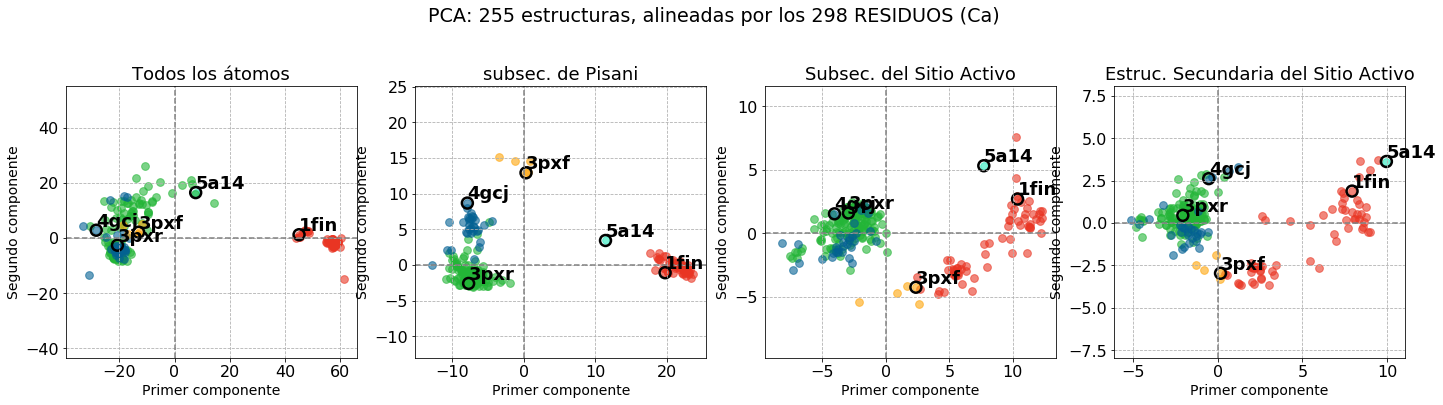

In [34]:
fig = plt.figure(figsize=(24, 5))
generate_new_aligns_pisani_structures( traj_crystals, "@CA")
plt.suptitle("PCA: 255 estructuras, alineadas por los 298 RESIDUOS (Ca)", y = 1.1);

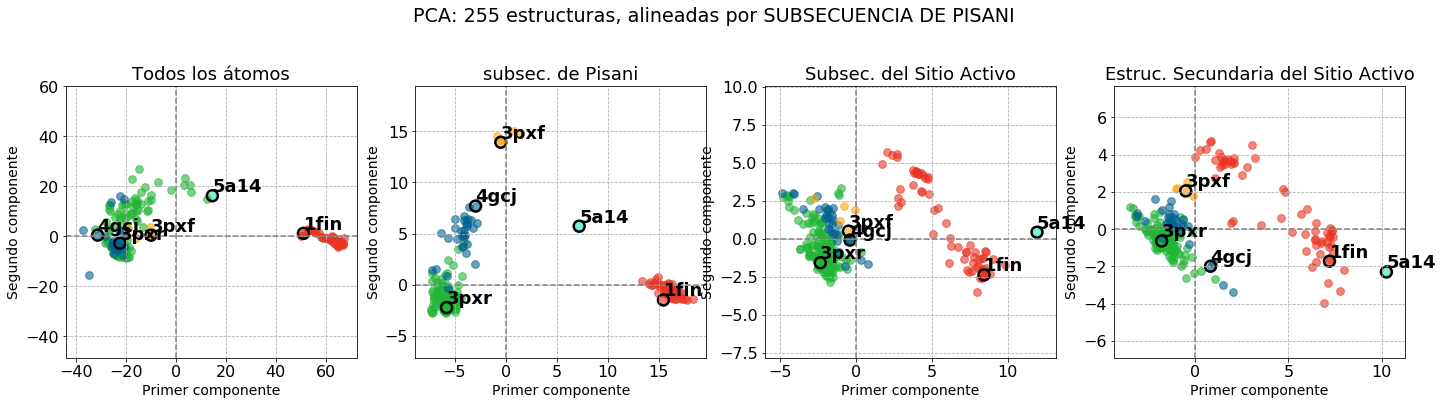

In [35]:
fig = plt.figure(figsize=(24, 5))
generate_new_aligns_pisani_structures( traj_crystals, F"(:{pisiani_residues})&(@CA)")
plt.suptitle("PCA: 255 estructuras, alineadas por SUBSECUENCIA DE PISANI", y = 1.1);

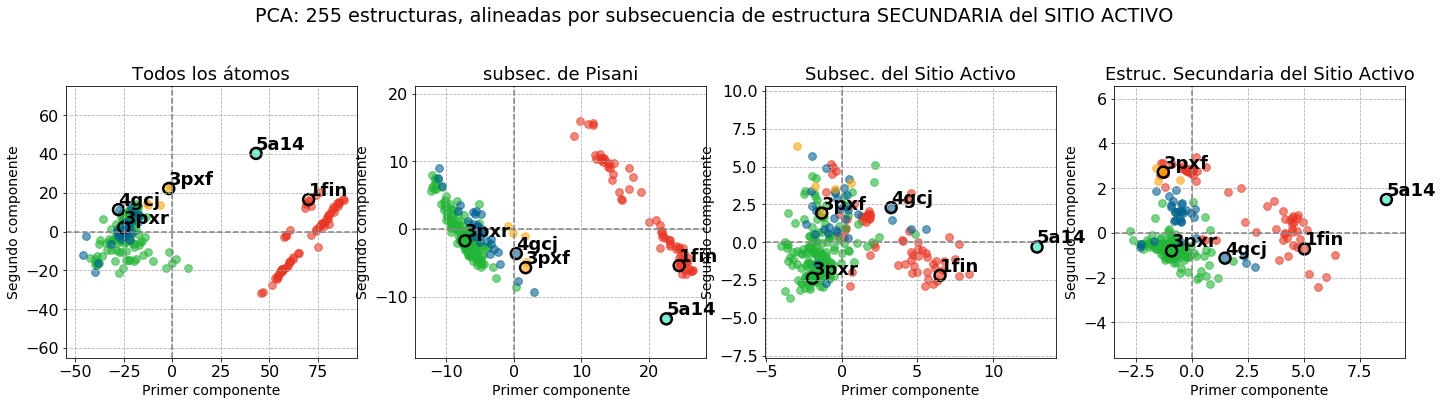

In [36]:
fig = plt.figure(figsize=(24, 5))
generate_new_aligns_pisani_structures( traj_crystals, F"(:{secondary_pk_index_string})&(@CA)")
plt.suptitle("PCA: 255 estructuras, alineadas por subsecuencia de estructura SECUNDARIA del SITIO ACTIVO", y = 1.1);

### Sitio activo etiquetado por ligando

El número de colores en la lista (2) es menor al número único de etiquetas (3).
El número de colores en la lista (2) es menor al número único de etiquetas (3).


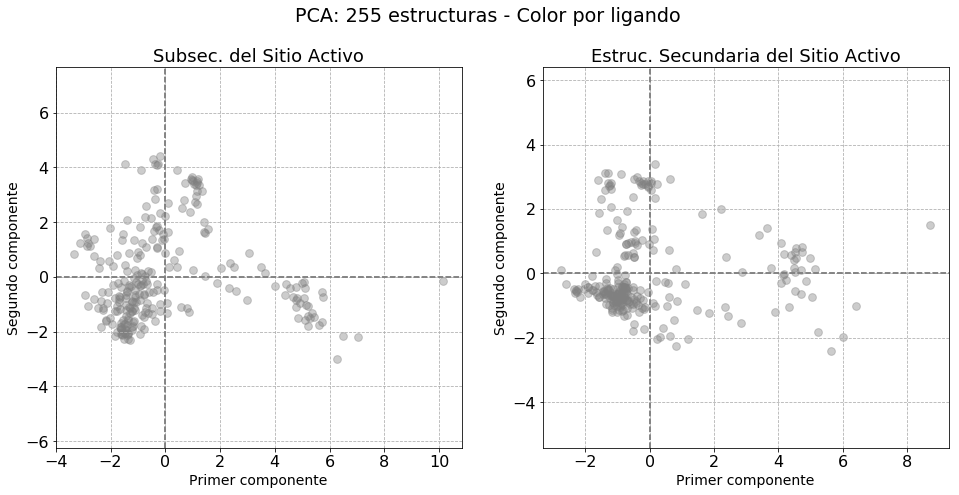

In [37]:
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plot_mds_or_pca(mds = pca_pyt_pocket.T, alpha = 0.4, colors_list=["gray"])
plot_mds_or_pca(mds = pca_pyt_pocket.T, labels = ligand_labels[frames_pisani], 
                colors_list = ligand_colors, alpha = 0.8,
                #dic_of_ref_labels = ref_structs_dict, traj_labels = df_cdk2[frames_pisani].index,
                             title = "Subsec. del Sitio Activo")
plt.subplot(1, 2, 2)
plot_mds_or_pca(mds = pca_pyt_pocket_sec.T, alpha = 0.4, colors_list=["gray"])
plot_mds_or_pca(mds = pca_pyt_pocket_sec.T, labels = ligand_labels[frames_pisani], 
                colors_list = ligand_colors, alpha = 0.8,
                #dic_of_ref_labels = ref_structs_dict, traj_labels = df_cdk2[frames_pisani].index,
                             title = "Estruc. Secundaria del Sitio Activo")
plt.suptitle("PCA: 255 estructuras - Color por ligando", y =1);

## cMDS usando POVME3
#### Evaluación directa del volumen del ligando

In [38]:
# Cargamos los valores del volumen del pocket
volumen_402_stc = pd.read_csv('../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_PISANI_402/res_volumes.tabbed.txt', sep = "\t", header=None)
volumen_402_stc.columns = ['frames', 'pocket_volume']
volumen_402_stc.frames = np.arange(0, len(volumen_402_stc.pocket_volume))
volumen_402_stc = np.array(volumen_402_stc).T

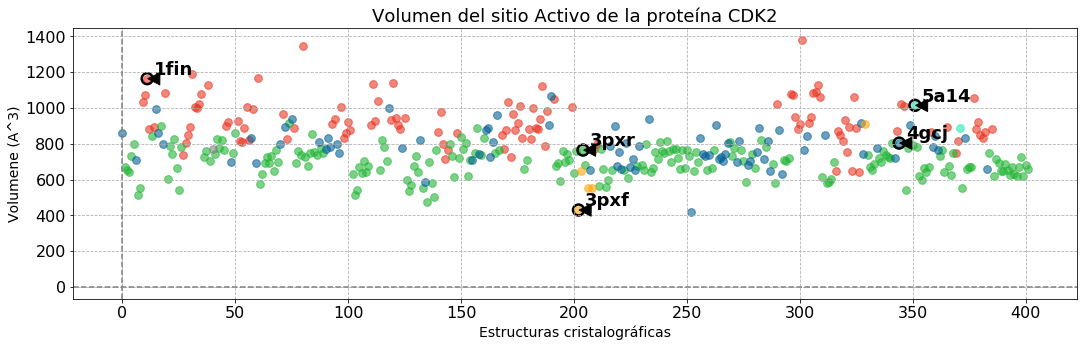

In [39]:
fig = plt.figure(figsize=(18, 5))
plot_mds_or_pca(volumen_402_stc, labels = df_cdk2.Labels_conf,
                equal_axis=False, xlabel = "Estructuras cristalográficas", ylabel = "Volumene (A^3)", 
                title = "Volumen del sitio Activo de la proteína CDK2")
plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), volumen_402_stc[0], volumen_402_stc[1], xytext_delta=[-3, 0.5], s=120)

#### Disimilitud del sitio activo por forma del pocket

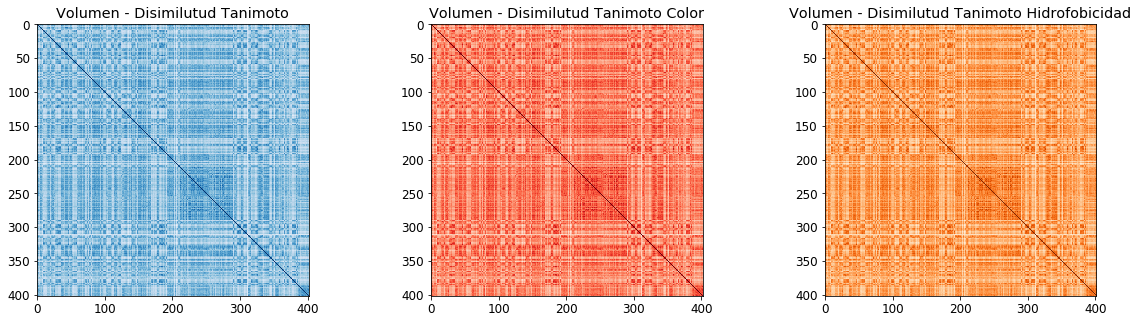

In [40]:
dir_volumen_results = '../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_PISANI_402/res_frameInfo/'

vol_tan_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix.csv', header=None)
vol_tan_col_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix_colored.csv', header=None)
vol_tan_hyfb_mtx = pd.read_csv(dir_volumen_results +'POVME_Tanimoto_matrix_hydrophobic.csv', header=None)

# visualizamos las matrices de volumen V
fig = plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 12})
plt.subplot(1, 3, 1)
plt.imshow(vol_tan_mtx , zorder=2, cmap='Blues', interpolation='nearest')
plt.title("Volumen - Disimilutud Tanimoto")
plt.subplot(1, 3, 2)
plt.imshow(vol_tan_mtx , zorder=2, cmap='Reds', interpolation='nearest')
plt.title("Volumen - Disimilutud Tanimoto Color")
plt.subplot(1, 3, 3)
plt.imshow(vol_tan_mtx , zorder=2, cmap='Oranges', interpolation='nearest')
plt.title("Volumen - Disimilutud Tanimoto Hidrofobicidad");

### cMDS utilizando el VOLUMEN


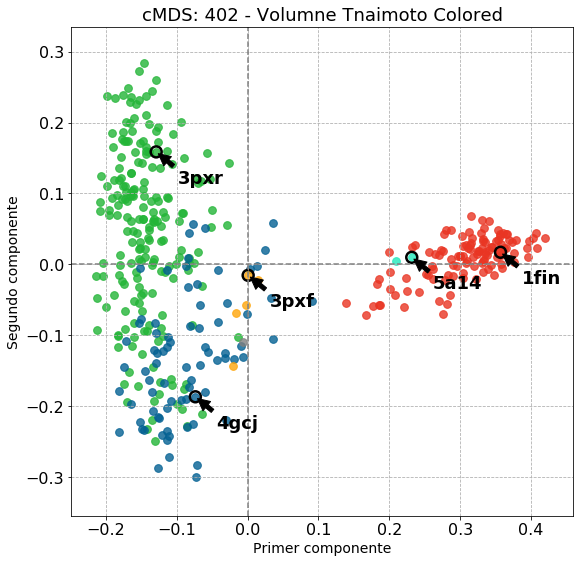

In [41]:
cdk2_tanimoto_vol_col = pd.read_csv(F'{dir_volumen_results}POVME_Tanimoto_matrix_colored.csv', header = None)
# Se calcula el cMDS usando la matriz de tanimoto menos uno
mds_tanimoto_vol_col = cMDS(cdk2_tanimoto_vol_col - 1)
# Plotting
fig = plt.figure(figsize=(9, 9))
plot_mds_or_pca(mds = mds_tanimoto_vol_col[0], labels = df_cdk2.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 - Volumne Tnaimoto Colored")
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), mds_tanimoto_vol_col[0][0], 
                      mds_tanimoto_vol_col[0][1], xytext_delta=[-0.03, 0.05], s=120)

### Color por Grupo de ligando y Volumen

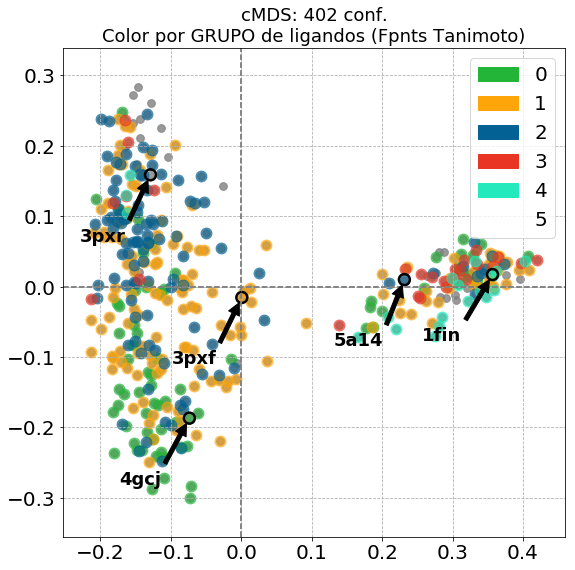

In [42]:
colores_grupo_lig = [ '#23B537', '#FEA50A', '#036193', '#E93523', '#23E9BC', 'none']

fig = plt.figure(figsize=(9, 9))
plot_mds_or_pca(mds = mds_tanimoto_vol_col[0], alpha = 0.8, colors_list=["gray"], general_font_size= 20)
plot_mds_or_pca(mds = mds_tanimoto_vol_col[0], labels = df_cdk2["Label_lig_g_tan"], colors_list = colores_grupo_lig, 
                legend=True, general_font_size= 20, xlabel="", ylabel="", point_size=120, alpha = 0.6,
                title = "cMDS: 402 conf.\nColor por GRUPO de ligandos (Fpnts Tanimoto)"
               )
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), 
                      mds_tanimoto_vol_col[0][0], mds_tanimoto_vol_col[0][1], xytext_delta=[0.1, 0.1], s=120)

### Gráficos de MDS utilizando diferentes propiedades de POVME
Primero usamos una función sencilla que realice el proceso de MDS y graficado a partir de un archivo *.csv* con la matriz de disimilitud.

In [43]:
def plot_mds_volumen(path, titulo):
    vol_tan_mtx = pd.read_csv(path, header=None)
    mds_total_vol = cMDS(vol_tan_mtx - 1)
    plot_mds_or_pca(mds = mds_total_vol[0], labels = df_cdk2.Labels_conf, title = titulo)
    plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), 
                          mds_total_vol[0][0], mds_total_vol[0][1], xytext_delta=[-0.03, 0.1], s=120)

### Plots utilizando la métrica Tanimoto

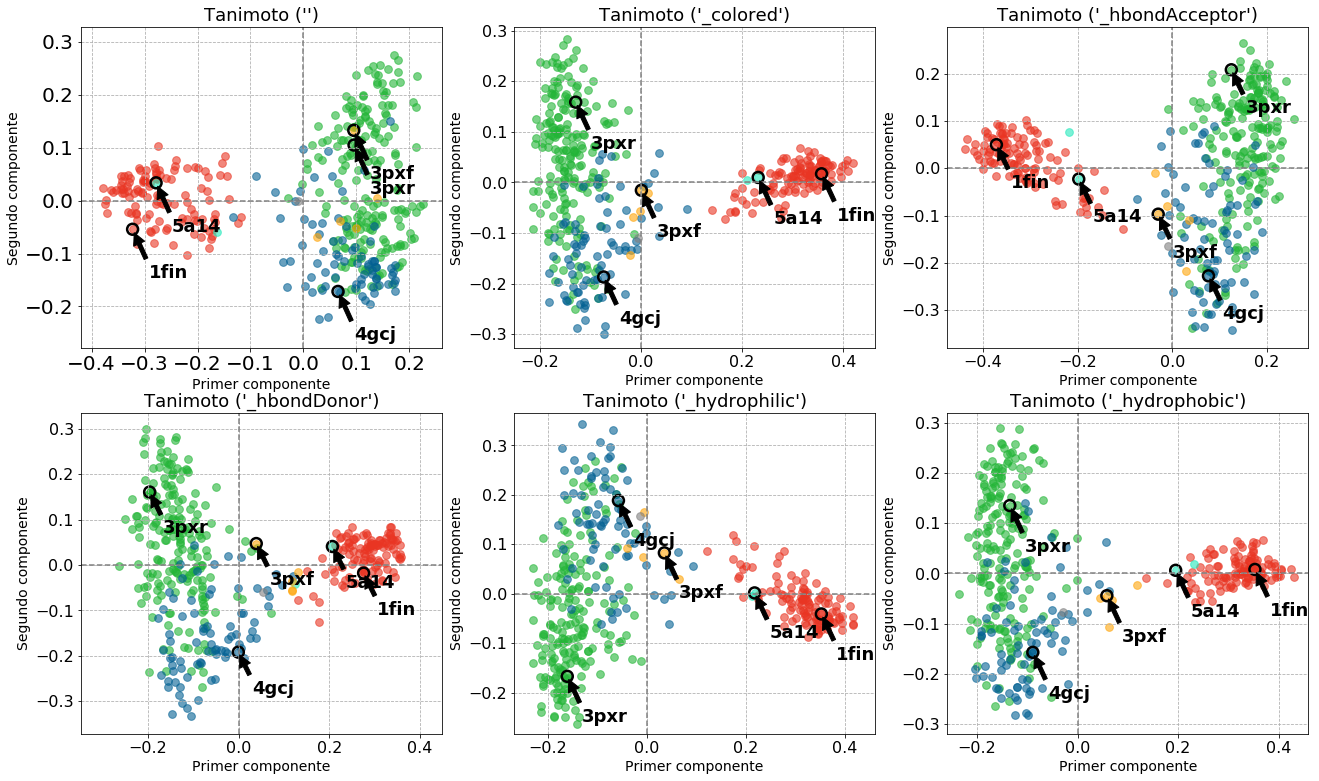

In [44]:
fig = plt.figure(figsize=(22, 13))
propiedades = ["", "_colored", "_hbondAcceptor", "_hbondDonor", "_hydrophilic", "_hydrophobic"]
for i, propiedad in enumerate(propiedades):
    plt.subplot(2, 3, i + 1)
    plot_mds_volumen(F'{dir_volumen_results}POVME_Tanimoto_matrix{propiedad}.csv', F"Tanimoto ('{propiedad}')")

### Plots utilizando la métrica Tversky

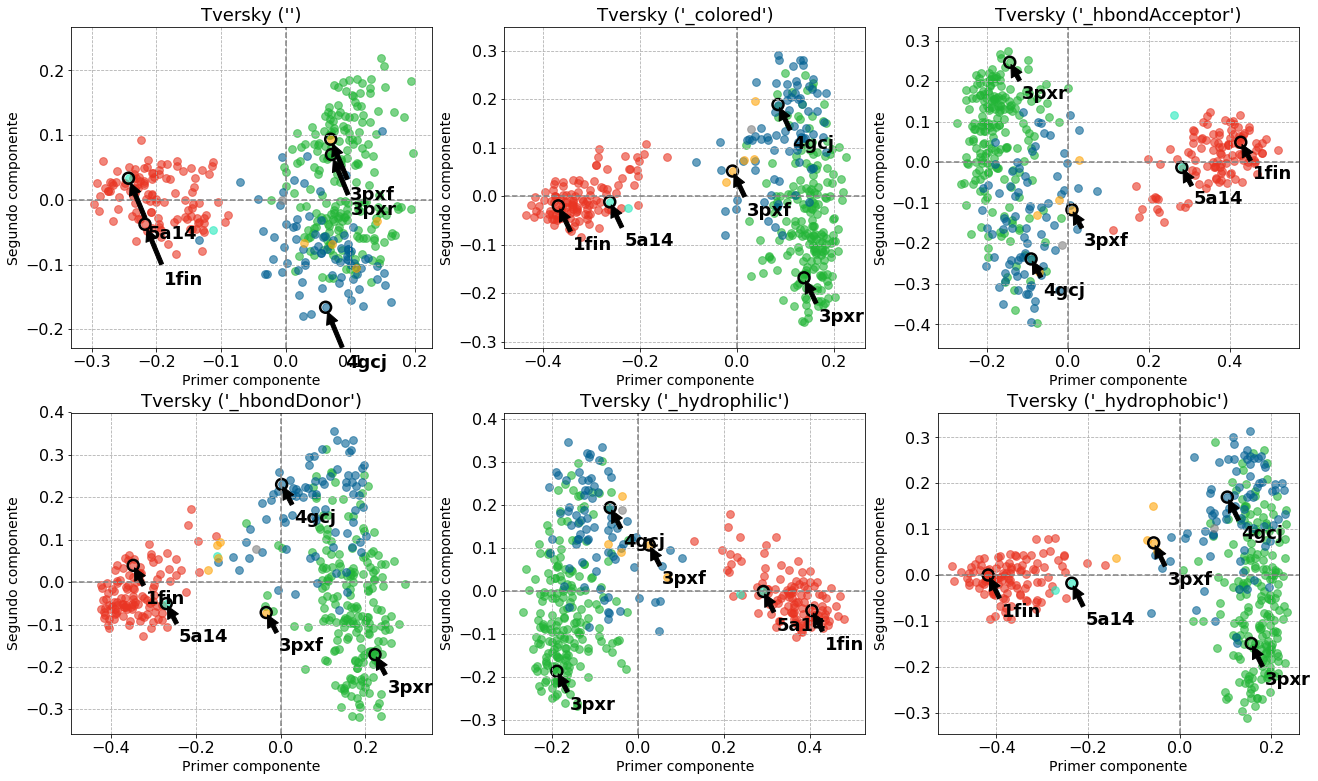

In [139]:
fig = plt.figure(figsize=(22, 13))
propiedades = ["", "_colored", "_hbondAcceptor", "_hbondDonor", "_hydrophilic", "_hydrophobic"]
for i, propiedad in enumerate(propiedades):
    plt.subplot(2, 3, i + 1)
    plot_mds_volumen(F'{dir_volumen_results}POVME_Tversky_matrix{propiedad}.csv', F"Tversky ('{propiedad}')")

### Combinando dos mediadas de disimilitud

In [262]:
# Juntamos las primeras dos dimensiones de cada MDS generado (RMSD y de Volumen con Tanimoto)
from scipy.spatial.distance import pdist, squareform
from scipy import stats

# Unimos las cuator dimensiones ( dos por cada MDS) y hacemos el reshape
new_dims_rd_vol = np.vstack((mds_total[0][0:2], mds_tanimoto_vol_col[0][0:2]**4)).T
d = pdist(new_dims_rd_vol,  'euclidean') # Calcula las distancias por pares
D = squareform(d) # Reorganiza los datos en una matrix cuadrada

print(mds_tanimoto_vol_col[0][0:2])
print(stats.zscore(mds_tanimoto_vol_col[0][0]))

[[ 0.00330538 -0.15825163 -0.1638801  ... -0.14313224 -0.13339918
  -0.14580249]
 [-0.00666741  0.15790138  0.12951044 ...  0.16048712  0.07329898
   0.28402571]]
[ 0.01633478 -0.78206027 -0.80987546 ... -0.70734209 -0.65924245
 -0.7205381 ]


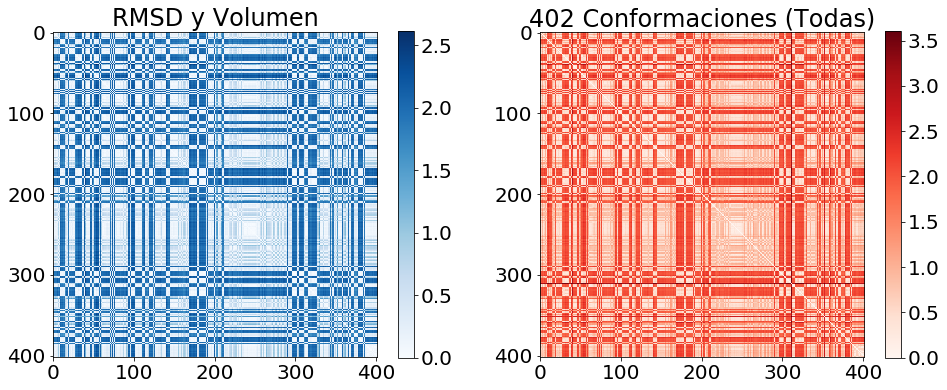

In [263]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 20})
plt.subplot(1, 2, 1)
plt.title("RMSD y Volumen")
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

plt.subplot(1, 2, 2)
plt.title("402 Conformaciones (Todas)")
plt.imshow(pair_rmsd_402_struc, zorder=2, cmap='Reds', interpolation='nearest')
plt.colorbar();

In [264]:
new_cmds = cMDS(D)

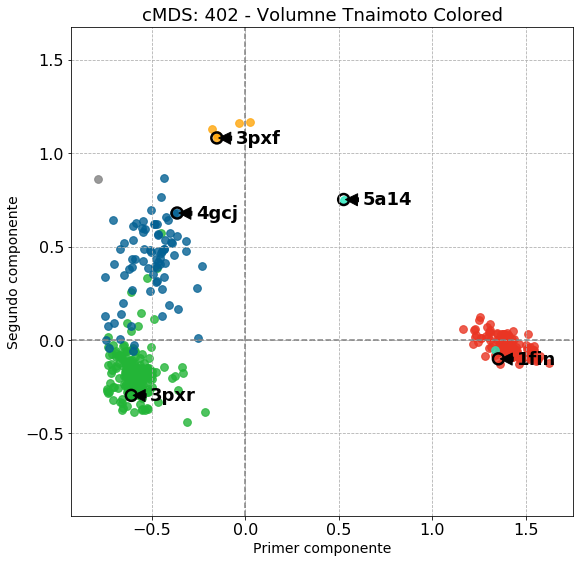

In [265]:
# Plotting
fig = plt.figure(figsize=(9, 9))
plot_mds_or_pca(mds = new_cmds[0], labels = df_cdk2.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 - Volumne Tnaimoto Colored")
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), new_cmds[0][0], 
                      new_cmds[0][1], xytext_delta=[-0.1, 0.05], s=120)

In [45]:
# Todos los carbonos alfa
from sklearn.manifold import TSNE
tsne_obj = TSNE( n_components= 2 )
# pca_obj = PCA(copy=True, n_components= 2)

def get_tsne(tsne_obj, traj, frames = -1, atom_mask = "@CA"):
    ''' Retorna un objeto pca dada una trayectoria de pytraj y una mascara de selección'''
    traj_subset = traj_crystals[frames, atom_mask]
    xyz_2d_array = traj_subset.xyz.reshape(traj_subset.n_frames, traj_subset.n_atoms * 3)
    tsne = tsne_obj.fit_transform( xyz_2d_array )
    return tsne

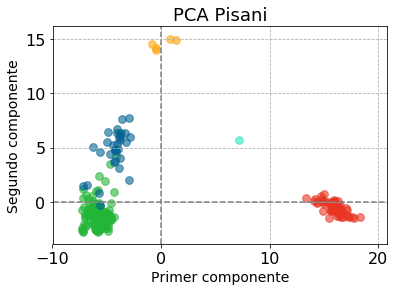

In [64]:
# Carbonos alfa de la subsecuencia de Pisani
pyt.align(traj_crystals, F"@CA")
tsne_pyt_pisani  = get_tsne(tsne_obj, traj_crystals, 
                            frames_pisani, F"@CA")



plot_mds_or_pca(mds = pca_pyt_pisani.T, labels = df_cdk2[frames_pisani].Labels_conf,
               title='PCA Pisani')

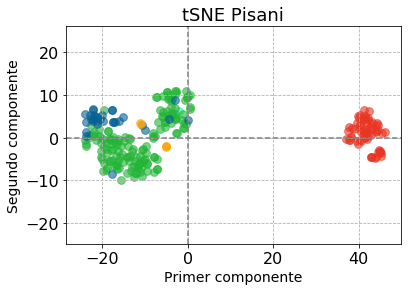

In [65]:
plot_mds_or_pca(mds = tsne_pyt_pisani.T, labels = df_cdk2[frames_pisani].Labels_conf,
               title='tSNE Pisani')

In [62]:
from bokeh.io import  show, output_file
from bokeh.models import ColumnDataSource, LassoSelectTool, ZoomInTool, ZoomOutTool, SaveTool, HoverTool,PanTool, Legend
from bokeh.plotting import figure
from bokeh.core.enums import LegendLocation

In [ ]:
def column_source(df, model_result, label):
    indices = 
    data = model_result[]